### Things to try
- Using Cabin and Ticket as features
- Implement Cross Validation
- Use a sklearn pipeline to simplify model

In [354]:
import pandas as pd

# Preprocessing

### Import Data

In [555]:
train_input = pd.read_csv('train.csv')
test_input = pd.read_csv('test.csv')

y = train_input.Survived

### Create Custom Features

In [556]:
# Create Last Name Column
def get_last_name(full_name):
    return full_name.split(', ')[0].lower()

train_input['Last_Name'] = train_input['Name'].apply(get_last_name)
test_input['Last_Name'] = test_input['Name'].apply(get_last_name)

In [557]:
# Create a column for each individual cabin letter
def split_cabin(cabin):
    return_vals = ['N/A'] * 4
    if type(cabin) == str:
        cabins = cabin.split(' ')
        for i, c in enumerate(cabins):
            if c[0].isalpha(): # First char is a letter
                return_vals[i] = c[0]
            else:
                return_vals[i] = 'N/A'
    else:
        pass
    
    return tuple(return_vals)

train_input['C1'], train_input['C2'], train_input['C3'], train_input['C4'] = zip(*train_input['Cabin'].apply(split_cabin))
test_input['C1'], test_input['C2'], test_input['C3'], test_input['C4'] = zip(*test_input['Cabin'].apply(split_cabin))

### Drop unwanted features

In [558]:
train_input = train_input.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
test_input = test_input.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

### Train Test Split
Train test split before preprocessing to prevent data leakage

In [559]:
from sklearn.model_selection import train_test_split

df_train_X, df_val_X, train_y, val_y = train_test_split(train_input, y.values, test_size=0.2)

In [560]:
from sklearn.preprocessing import Imputer

def preprocess_data(X):
    # Add dataframe columns signifying where missing data is located......    
    cols_with_missing = (col for col in X.columns if X[col].isnull().any()) # Get columns with missing data

    for col in cols_with_missing:
        X[col + '_missing'] = X[col].isnull()
        
    # One hot encode data..................................................
    ohe_X = pd.get_dummies(X)
    
    # Fit missing data using imputation....................................
    imputer = Imputer()
    imputed_X = pd.DataFrame(imputer.fit_transform(ohe_X))
    imputed_X.columns = ohe_X.columns
    
    return imputed_X

In [561]:
df_train_X = preprocess_data(df_train_X)
df_val_X = preprocess_data(df_val_X)

# Match feature names and count for both train and val dataframes
full_cols = df_train_X.append(df_val_X)
full_cols = full_cols.drop(full_cols.index)
df_train_X = full_cols.append(df_train_X)
df_val_X = full_cols.append(df_val_X)

titanic_test_X = preprocess_data(test_input)

C:\Users\stephen\AppData\Local\conda\conda\envs\tfgpu1.1\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [562]:
# Get just data, drop dataframe
train_X = df_train_X.values
val_X = df_val_X.values

# Train Data

### Find optimal model cycle count n_estimators

In [566]:
import matplotlib
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

def get_train_val_data(plot_range):
    val_mean_error = []
    train_mean_error = []
    for n in plot_range:  
        model = XGBRegressor(n_estimators=n, learning_rate=.1)
        model.fit(train_X, train_y)

        predictions = model.predict(val_X)
        val_mean_error += [mean_absolute_error(predictions, val_y)]

        predictions = model.predict(train_X)
        train_mean_error += [mean_absolute_error(predictions, train_y)]
    return train_mean_error, val_mean_error

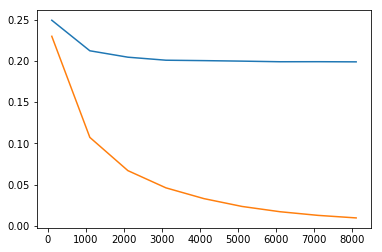

In [569]:
# Broad plot
test_range = range(100, 9100, 1000)
train_mean_error, val_mean_error = get_train_val_data(test_range)
plt.plot(test_range, val_mean_error, test_range, train_mean_error)
plt.show()

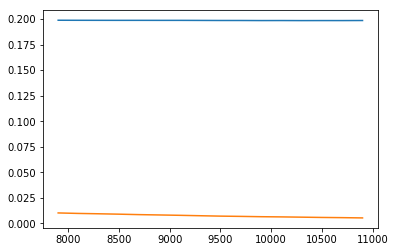

In [571]:
# Narrow plot
test_range = range(7900, 11000, 200)
train_mean_error, val_mean_error = get_train_val_data(test_range)
plt.plot(test_range, val_mean_error, test_range, train_mean_error)
plt.show()

### Get best n

In [572]:
idx_of_min_err = val_mean_error.index(min(val_mean_error))
best_err = val_mean_error[idx_of_min_err]
best_n = list(test_range)[idx_of_min_err]
print('Index: {0}, Value: {1:0.4f}, n_estimator: {2}'.format(idx_of_min_err, best_err, best_n))

Index: 12, Value: 0.1985, n_estimator: 10300


# Train Full Data Set

In [406]:
# Train on full data set with optimal model cycle count
model = XGBRegressor(n_estimators=best_n, learning_rate=.01)
model.fit(titanic_X.values, y.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=2100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# Predict on Test Set

In [337]:
final_predictions = model.predict(titanic_test_X.values)

# Convert to boolean values
final_bool = [1 if p > 0.5 else 0 for p in final_predictions]

In [35]:
# Export predictions for submission
output = pd.DataFrame({'PassengerId': test_input.PassengerId, 'Survived': final_bool})
output.to_csv('submission.csv', index=False)

# Partial Dependency Plots
How each feature affects the model

In [338]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import matplotlib
%matplotlib inline

partial_dependence_model = GradientBoostingRegressor()
partial_dependence_model.fit(titanic_X.values, y.values)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

### Age vs Survival Likelihood
More likely to survive if younger

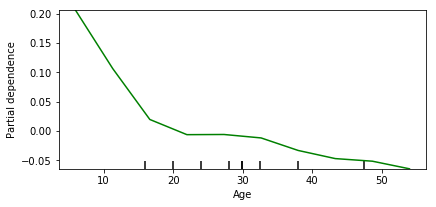

In [32]:
plotter = plot_partial_dependence(partial_dependence_model, 
                                  features=[0], # Column numbers of plots to show
                                  X=titanic_X.values, 
                                  feature_names=list(titanic_X.columns),
                                 grid_resolution=10)

### Fare Price vs Surival Likelihood
More likely to survive if payed more for fare

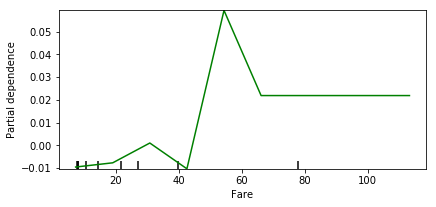

In [33]:
plotter = plot_partial_dependence(partial_dependence_model, 
                                  features=[1], # Column numbers of plots to show
                                  X=titanic_X.values, 
                                  feature_names=list(titanic_X.columns),
                                 grid_resolution=10)

### Parent Child Count vs Survival Likelihood
More likely to survive with fewer parent/child count (probably fewer children)

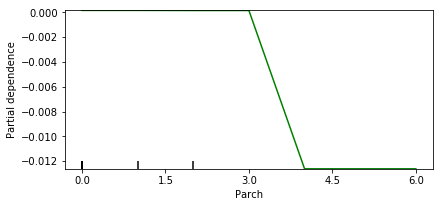

In [34]:
plotter = plot_partial_dependence(partial_dependence_model, 
                                  features=[2], # Column numbers of plots to show
                                  X=titanic_X.values, 
                                  feature_names=list(titanic_X.columns),
                                 grid_resolution=10)

### Travel Class vs Survival Likelihood
More likely to survive if 1st Class

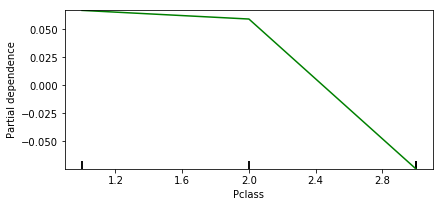

In [132]:
plotter = plot_partial_dependence(partial_dependence_model, 
                                  features=[3], # Column numbers of plots to show
                                  X=titanic_X.values, 
                                  feature_names=list(titanic_X.columns),
                                 grid_resolution=10)

### Sibling Count vs Survival Likelihood
Less siblings increased survival likelihood

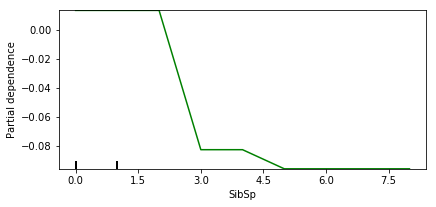

In [133]:
plotter = plot_partial_dependence(partial_dependence_model, 
                                  features=[4], # Column numbers of plots to show
                                  X=titanic_X.values, 
                                  feature_names=list(titanic_X.columns),
                                 grid_resolution=10)

In [343]:
titanic_X.columns.values

array(['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Age_missing',
       'Embarked_missing', 'Fare_missing', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Sex_female', 'Sex_male', 'C1_Ch_A', 'C1_Ch_B',
       'C1_Ch_C', 'C1_Ch_D', 'C1_Ch_E', 'C1_Ch_F', 'C1_Ch_G', 'C1_Ch_N/A',
       'C1_Ch_T', 'C1_N_', 'C1_N_10', 'C1_N_101', 'C1_N_102', 'C1_N_103',
       'C1_N_104', 'C1_N_105', 'C1_N_106', 'C1_N_11', 'C1_N_110',
       'C1_N_111', 'C1_N_116', 'C1_N_118', 'C1_N_12', 'C1_N_121',
       'C1_N_123', 'C1_N_124', 'C1_N_125', 'C1_N_126', 'C1_N_128',
       'C1_N_130', 'C1_N_132', 'C1_N_14', 'C1_N_148', 'C1_N_15',
       'C1_N_16', 'C1_N_17', 'C1_N_18', 'C1_N_19', 'C1_N_2', 'C1_N_20',
       'C1_N_21', 'C1_N_22', 'C1_N_23', 'C1_N_24', 'C1_N_25', 'C1_N_26',
       'C1_N_28', 'C1_N_29', 'C1_N_3', 'C1_N_30', 'C1_N_31', 'C1_N_32',
       'C1_N_33', 'C1_N_34', 'C1_N_35', 'C1_N_36', 'C1_N_37', 'C1_N_38',
       'C1_N_39', 'C1_N_4', 'C1_N_40', 'C1_N_41', 'C1_N_42', 'C1_N_43',
       'C1_N_44', 'C

### Cabin vs Survival Likelihood

In [176]:
from collections import Counter
import math
cnt = Counter()

In [177]:
cabin_survival = {}
for c, s in zip(train_input['Cabin'], train_input['Survived']):
    # If NaN, skip
    if type(c) == float:
        continue
    cnt.update({c: s})

In [191]:
cnt.most_common()

[('B96 B98', 4),
 ('F33', 3),
 ('E101', 3),
 ('D17', 2),
 ('B28', 2),
 ('F2', 2),
 ('E24', 2),
 ('E25', 2),
 ('D20', 2),
 ('C52', 2),
 ('C125', 2),
 ('B35', 2),
 ('C23 C25 C27', 2),
 ('B18', 2),
 ('B77', 2),
 ('F4', 2),
 ('B20', 2),
 ('G6', 2),
 ('B49', 2),
 ('D33', 2),
 ('D36', 2),
 ('B5', 2),
 ('E121', 2),
 ('E33', 2),
 ('E8', 2),
 ('C126', 2),
 ('D', 2),
 ('C92', 2),
 ('B57 B59 B63 B66', 2),
 ('D35', 2),
 ('C93', 2),
 ('C68', 1),
 ('D11', 1),
 ('D10 D12', 1),
 ('A34', 1),
 ('C148', 1),
 ('E40', 1),
 ('B41', 1),
 ('A26', 1),
 ('A20', 1),
 ('C99', 1),
 ('E36', 1),
 ('C103', 1),
 ('E68', 1),
 ('B69', 1),
 ('B22', 1),
 ('C50', 1),
 ('A31', 1),
 ('B50', 1),
 ('C2', 1),
 ('C32', 1),
 ('B80', 1),
 ('C7', 1),
 ('B3', 1),
 ('C90', 1),
 ('C104', 1),
 ('B4', 1),
 ('D21', 1),
 ('D47', 1),
 ('C47', 1),
 ('D49', 1),
 ('B79', 1),
 ('A6', 1),
 ('B39', 1),
 ('A23', 1),
 ('E12', 1),
 ('B51 B53 B55', 1),
 ('B101', 1),
 ('A16', 1),
 ('C22 C26', 1),
 ('F E69', 1),
 ('B78', 1),
 ('C101', 1),
 ('D56', 1),